DSL 5기 한영웅님의 CNN 1강 코드를 일부 수정하였음을 알려드립니다.

(이 노트북은 최건호, 파이토치 첫걸음 , 한빛미디어 ,2019 를 참고하여 초기 제작 되었습니다)

## 1. 모듈 불러오기

In [2]:
import torch 
import torch.nn as nn # neural network가 담겨있는 모듈
import torch.optim as optim  # optimizer가 담겨있는 모듈
import torch.nn.init as init # neural network를 초기화 하는 모듈. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행 

import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈
import torchvision.transforms as transforms # 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수를 불러오는 모듈
import numpy as np

import matplotlib.pyplot as plt

print(torch.__version__)


1.10.0+cu111


## 2. 데이터 다운 

In [3]:
#모듈을 통해 torchvision에서 제공하는 데이터를 쉽게 다운받을 수 있습니다. 
#root는 불러들인 데이터가 저장되는 곳, train은 학습데이터인지에 대한 여부, transform은 데이터 변환함수를 넣는 인자, 
#target_transform은 label(정답)데이터 또한 변환할 것인지에 대한 여부 
#download는 지정된 경로에 데이터가 없다면 다운받을 것인지에 대한 여부를 묻습니다.

mnist_train=dset.MNIST(root='../',train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST(root='../',train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [4]:
# 데이터 셋 체크 getitem을 써도 되고, 인덱싱을 통해서 확인도 가능
# 데이터 하나가 가진 크기 확인 필수! 입력의 사이즈를 알아야 그에 맞게 모델 구현 가능
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
# print(mnist_train[0])

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


## 3. 하이퍼 파라미터 

In [5]:
# CNN의 대표적인 하이퍼 파라미터 num_epoch, batch_size, learnin_rate

num_epoch=10
batch_size=256
learning_rate= 0.0002

## 4. 데이터 로더 정의하기 

- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [6]:
# 위에서 데이터 전부를 정의해 mnist_train에는 모든 학습 데이터가 들어있는 상태
# 모든 학습 데이터를 한 번에 학습하면 과부하가 발생
# 그래서 데이터를 조금씩 조금씩 쪼개서 학습하기 위해 DataLodaer 사용

train_loader=DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 5. 모델 정의하기 

Conv(1,16,5)->ReLu->Conv(16,32,5)->ReLu->MaxPool2d(2,2)->Conv2d(32,64,5)->ReLu->MaxPool2d(2,2)->fc

dropout 적용

In [7]:
# 모델 정의 시 유념해야할 건 각 층의 결과물의 사이즈
# 모델이 복잡해지면 복잡해질수록 이는 더욱 중요해지므로 레이어별로 도출되는 데이터의 크기를 써넣는 것을 추천
# 해당 모델은 임의로 만든 모델로 성능을 보장하지 X

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),
            nn.Dropout2d(0.2),                                                         # 필터의 개수(16개) 임의로 설정 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례로 수행
        out = out.view(out.size(0),-1)                                           # view 함수를 이용해 텐서를 flatten 
                                                                                # ex) 2x3 텐서를 .view(1,-1) 해주면 1x6으로, view(3,-1)이면 3x2로
                                                                                # !전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류!
        out = self.fc_layer(out)
        return out

파이토치 - torch.nn (Conv2d 설명 확인)
https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d

파이토치 - TORCH.TENSOR
https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view

## 6. 손실함수와 최적화 함수 정의하기 

In [8]:
# gpu나 cpu를 device로 불러 device에서 학습이 진행되게끔 모델을 device에 올리기
# loss function과 optimizer도 정의해야 

device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=CNN().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.01) # L2 regularization

cuda:0


In [ ]:
!pip install torchsummary

You should consider upgrading via the 'c:\users\82105\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
from torchsummary import summary
summary(model,(1,28,28), batch_size=256)          # 파이토치는 입력을 (channel, width, height) 순으로

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 24, 24]             416
              ReLU-2          [256, 16, 24, 24]               0
            Conv2d-3          [256, 32, 20, 20]          12,832
              ReLU-4          [256, 32, 20, 20]               0
         MaxPool2d-5          [256, 32, 10, 10]               0
            Conv2d-6            [256, 64, 6, 6]          51,264
              ReLU-7            [256, 64, 6, 6]               0
         MaxPool2d-8            [256, 64, 3, 3]               0
            Linear-9                 [256, 100]          57,700
             ReLU-10                 [256, 100]               0
           Linear-11                  [256, 10]           1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/

## 7. 학습하기 

In [9]:
loss_arr=[]

for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)            # 학습이미지
    y_=label.to(device)           # 정답을 device에 올리고.
    optimizer.zero_grad() 
    output=model.forward(x)       # 학습이미지를 모델에 돌린 결과
    loss=loss_func(output,y_)     # 결과와 정답을 loss function에 넣고 loss를 추출
    loss.backward()               # 추출된 loss를 통해 역전파
    optimizer.step()              # 역전파를 했다면 optimizer.step()를 통해 파라미터를 이동
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1737, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>)


## 8. 손실 시각화 

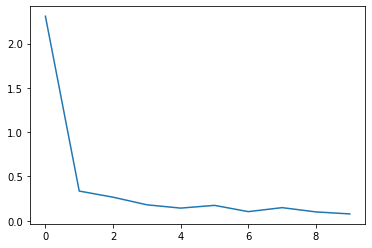

In [10]:
plt.plot(loss_arr)
plt.show()

## 9. 테스트 하기 

In [11]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
    _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

    total+=label.size(0)

    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 96.98517608642578%
